### ARDC Burnt Area Validation Workflow ###
This notebook contains several modules to validate the results of burnt area algorithms against data from the ARDC historical burnt area dataset.  
    - Module 1 : Download Burncube rasters from AWS and store locally  
    - Module 2 : Extract vector validation data from the ARDC Historical Fire dataset  
    - Module 3 : Validate the results of the burnt area algorithm  
    - Module 4 : Thematic Analysis of Results
    
### Notebook Setup ###
Import required libraries and tools, as well as define required user inputs.

In [1]:
# Import libraries required for AWS download
import sys
import os
import re
import boto3
import botocore

# Import libraries required for ARDC dataset extraction and validation modules
import rasterio
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import contextily as cx
import datacube
import xarray as xr
import numpy as np
import rioxarray
import getpass
import matplotlib.patheffects as path_effects
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Rectangle

# Import tools and functions from ARDC_burnt_area_mapping_tools.py
from ARDC_burnt_area_mapping_tools import (
    gen_grid_codes,
    download_s3_files,
    ardc_year_calc,
    raster_folder_bbox,
    ValidationStats,
    ReadShapes,
    GetTifs,
    extract_xy,
    calculate_classification_metrics,
    validation_climate_analysis,
)

# Import tools and functions from DEA tools
from dea_tools.spatial import xr_vectorize, xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog

# Set AWS environment variable
os.environ["AWS_NO_SIGN_REQUEST"] = "yes"

### User Defined Variables ###
The following variables must be defined by the user to match the burnt area algorithm being validated. This involves setting several variables to the the model output s3 location, as well as defining the AU30 tiles and time period of the study period.

User defined variables are split into three categories for clarity:
1. Burnt Area Algorithm Product Parameters
2. Validation Location and Time Period Parameters
3. Thematic Climate Analysis Parameters

#### Burnt Area Algorithm Product Parameters ####

In [2]:
#Define required user inputs 
#Examples will be given using the following s3 object path
#http://dea-public-data-dev.s3-website-ap-southeast-2.amazonaws.com/?prefix=projects/burn_cube/derivative/ga_ls8c_nbart_bc_cyear_3/
#3-0-0/x14/y21/2020-01-01--P1Y/ga_ls8c_nbart_bc_cyear_3_x14y21_2020-01-01--P1Y_final_wofssevere.tif

#Directory date string
#E.g. '2020-01-01'
dir_date = "2020-01-01"

#Define the suffix for the desired files
# E.g. 'wofssevere'
suffix = 'demo'

#Define the files type
#E.g. 'tif'
inputType = 'tif'

#### Validation Location  and Time Period Parameters ####

In [3]:
#What is the path to the ARDC dataset?
ardc_fname = 'ARDC_fire_2010.shp'

#What is the path to the coastline dataset?
CoastLineShapeFile = 'ITEMCoastlineCleaned.shp'

#Define the colour scheme to be used in validation figures
colpac = ['#000000', '#e69f00', '#57b4e9', '#019e73', '#f0e442']

#Are we analysing data on a CY of FY basis?
year_basis = "CY"

#What year are we analysing? If using a FY basis, enter the first year over the period (i.e. for 19/20 enter 2019)
year = 2020

#If calculating on a CY year basis, do you want to extend the validation period to capture fires
#that ignited in the early summer months (i.e. 1 for december and 2 for novemeber)?
extra_months = 1

#### Thematic Climate Analysis Parameters ####

In [4]:
#Define a location name and year for your validation AOI. Use '_' instead of spaces.
vali_year = str(year) + " " + year_basis

#Set filepath for the Climate Zone Shapefile and legend
ClimateZoneShapeFile = 'Koppen_Climate_Zones.shp'
ClimateLegend_fname = 'legend.txt'

### Module 1: Download Burncube rasters from AWS and store locally ###

Download files from a Public AWS s3 bucket and save locally in a folder.

### Module 2: Extract vector validation data from the ARDC Historical Fire dataset ###
This module calculates the geographical extent of the geotifs downloaded in module 1, and uses this to filter the ARDC dataset for overlapping validation data.

Additionally, the ARDC dataset is filtered for the year being analysed.

The ARDC dataset can be downloaded [here](https://ecat.ga.gov.au/geonetwork/srv/api/records/a82c263f-dba6-457a-aafd-bf869fe7171a)# Define a style function for the visualisation of the results



In [5]:
# Define a style function for the visualisation of the results
def result_visuals(styler, study_site):
    styler.set_caption(
        "Climate Class Validation Results for {}, {}".format(study_site.replace("_", " "), vali_year)
    )
    styler.format(
        {
            "Precision": lambda x: f"{x*100:.1f}%",
            "Recall": lambda x: f"{x*100:.1f}%",
            "Area_Percent": lambda x: f"{x*100:.1f}%",
        }
    )
    styler.background_gradient(
        subset=["Precision", "Recall"], vmin=0.3, vmax=1, cmap="RdYlGn"
    )
    return styler



In [6]:
def generate_result_by_study_site_folder(algo_name, save_folder, study_site):
    
    year = 2020
    
    polygon, poly_crs = raster_folder_bbox(save_folder)
        
    time_period = ardc_year_calc(year_basis, year, extra_months)
    
    #Load the ARDC shapefile into a gdf
    ardc_gdf = gpd.read_file(ardc_fname)

    #Create a gdf using the polygon object created from the extent of BC geotifs
    #Set its crs and transform to the ardc_gdf crs
    poly_gdf = gpd.GeoDataFrame(geometry=[polygon])
    poly_gdf = poly_gdf.set_crs(poly_crs)
    poly_gdf = poly_gdf.to_crs(ardc_gdf.crs)

    #Change crs of both gdf to 3577
    #ardc_gdf = ardc_gdf.to_crs(3577)
    poly_gdf = poly_gdf.to_crs(3577)
    
    shapefile_outpath = "{}_{}_{}_ARDC_polygons.shp".format(
        study_site, year, year_basis
    )

    ardc_gdf_fil = gpd.read_file(shapefile_outpath)
    FigTitle = f"{algo_name} Results for {study_site} {year}-{year_basis}"
    GroundTruthFile = shapefile_outpath
    GTF, CLSF, StateBndry = ReadShapes(GroundTruthFile, CoastLineShapeFile)
    
    TifList = GetTifs(save_folder, suffix)

    TifC = []
    
    for i in TifList:
        xx, yy = extract_xy(i)
        TifC.append([xx,yy])
    TifCoords = str(TifC)[1:-1]

    print(study_site, algo_name, TifList)

    # Create single xarray out of combined True/False/Positive/Negative tiles
    CombineList = []
    TPTotal, FNTotal, FPTotal, TNTotal = 0, 0, 0, 0
    for i, item in enumerate(TifList):
        Comby, TP, FN, FP, TN = ValidationStats(item, GTF, CLSF, StateBndry, inputType, colpac, GraphOut=False)
        Comby.name = 'var'
        CombineList.append(Comby)
        TPTotal += TP
        FNTotal += FN
        FPTotal += FP
        TNTotal += TN
        
    try:
        CombineArray = xr.merge(CombineList).to_array()
        print("CombineArray created by xarray merge")
    except xr.MergeError:
        CombineArray = xr.combine_by_coords(CombineList).to_array()
        print("CombineArray created by xarray combine_by_coords")

    metric_list = ["precision", "recall", "f1-score"]
    accuracy_metrics = calculate_classification_metrics(TP = TPTotal, TN = TNTotal, FP = FPTotal, FN = FNTotal, metrics = metric_list)
    print(study_site, algo_name, accuracy_metrics)

    # Precision = TP/(TP+FP)
    if TPTotal+FPTotal > 0 and TPTotal > 0:
        Prec =  round(100*accuracy_metrics["precision"], 1)
        PrecStr = 'Precision = ' + str(Prec) + '%'
    else:
        PrecStr = 'Precision is undefined'

    # Recall = TP/(FN+TP)
    if FNTotal+TPTotal > 0 and TPTotal > 0:
        Rec = round(100*accuracy_metrics["recall"], 1)
        RecStr = 'Recall = ' + str(Rec) + '%'
    else:
        RecStr = 'Recall is undefined'

    # Total pixels
    Total = TPTotal+FPTotal+TNTotal+FNTotal

    PrintString = 'True Positive: ' + str("{:.2g}".format(100*TPTotal/Total)) + '%\nTrue Negative: ' + str("{:.2g}".format(100*TNTotal/Total)) + \
                      '%\nFalse Positive: ' + str("{:.2g}".format(100*FPTotal/Total)) + '%\nFalse Negative: ' + str("{:.2g}".format(100*FNTotal/Total)) + '%' + \
                      PrecStr + RecStr

    TPStr = 'True Positive: ' + str("{:.2g}".format(100*TPTotal/Total)) + '%'
    FNStr = 'False Negative: ' + str("{:.2g}".format(100*FNTotal/Total)) + '%'
    FPStr = 'False Positive: ' + str("{:.2g}".format(100*FPTotal/Total)) + '%'
    TNStr = 'True Negative: ' + str("{:.2g}".format(100*TNTotal/Total)) + '%'
    
    uniqVals = np.unique(CombineArray)

    # Remove nan from unique values and convert remaining floats to ints
    colnums = uniqVals[~np.isnan(uniqVals)].astype(int)

    # Select only colours that correspond to data values in array
    colpac2= [colpac[i] for i in colnums]

    #
    # Make final plot
    #
    fig, axes = plt.subplots(1, 1, figsize=(12,12))
    plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)

    CombineArray[0].plot(ax=axes, levels=[0.5,1.5,2.5,3.5,4.5], colors=colpac2, add_colorbar=False)

    strDic = {0: TPStr, 1: FNStr, 2: FPStr, 3: TNStr, 4: PrecStr, 5: RecStr}
    #colDic = {0: colpac2[0], 1: colpac2[3], 2: colpac2[2], 3: colpac2[1]}

    for i in range(6):
        axes.text(1.04, 0.98-(0.04*i), strDic[i], ha='left', va='center', size=14, color='k', transform = axes.transAxes)
        if i<4:
            rect = Rectangle((1.01, 0.97-(0.04*i)), 0.025, 0.025, linewidth=1.5, edgecolor='black', facecolor=colpac[i+1], clip_on=False, transform = axes.transAxes)
            axes.add_patch(rect)

    axes.set_aspect('equal', adjustable='box')

    axes.set_title(FigTitle)

    #Define the filename of the output png image and export to png
    png_filepath = f"{save_folder}/{algo_name}_{study_site}-{year}-{year_basis}.png"
    plt.savefig(png_filepath, dpi=300)
    
    # Save combined array as tiff
    tif_filepath = f"{save_folder}/{algo_name}_{study_site}-{year}-{year_basis}.tif"

    write_cog(geo_im=CombineArray,
              fname=tif_filepath,
              overwrite=True)

    #
    # Write out metadata
    #
    metadata = {
        #'date': datetime.now(),
        #'user': getpass.getuser(),
        'Location' : study_site.replace("_", " "),
        'Algorithm' : algo_name,
        #'AU30 Tiles' : TifCoords,
        #'Validation Data' : GroundTruthFile,
        #'Validation CRS' : gpd.read_file(GroundTruthFile).crs,
        #'Validation ARDC time period' : time_period,
        #'Validation ARDC spatial extent' : polygon,
        #'Coastline Data' : CoastLineShapeFile,
        'Precision' : Prec,
        'Recall' : Rec,
        'Total Pixels': Total,
        'True Positive Pixels': TPTotal,
        'False Positive Pixels': FPTotal,
        'True Negative Pixels': TNTotal,
        'False Negative Pixels': FNTotal

    }
    
    metadata_dict = {
        #'date': datetime.now(),
        #'user': getpass.getuser(),
        'Location' : [study_site.replace("_", " ")],
        'Algorithm' : [algo_name],
        #'AU30 Tiles' : TifCoords,
        #'Validation Data' : GroundTruthFile,
        #'Validation CRS' : gpd.read_file(GroundTruthFile).crs,
        #'Validation ARDC time period' : time_period,
        #'Validation ARDC spatial extent' : polygon,
        #'Coastline Data' : CoastLineShapeFile,
        'Precision' : [Prec],
        'Recall' : [Rec],
        'Total Pixels': [Total],
        'True Positive Pixels': [TPTotal],
        'False Positive Pixels': [FPTotal],
        'True Negative Pixels': [TNTotal],
        'False Negative Pixels': [FNTotal]

    }
    
    import pandas as pd
    result_df = pd.DataFrame.from_dict(metadata_dict)

    with open(f"{save_folder}/{algo_name}_{study_site}-{year}-{year_basis}.txt", 'w') as f:
        for key, value in metadata.items():
            f.write(f"{key}: {value}\n")
            
    result_df.to_csv(f"{save_folder}/{algo_name}_{study_site}-{year}-{year_basis}.csv", index=False)

    climate_df = validation_climate_analysis(tif_filepath, ClimateZoneShapeFile, ClimateLegend_fname, study_site, vali_year)
    
    
    # Visualise the results in table format
    climate_df.style.pipe(result_visuals, study_site)
    
    # Get the climate classes and their corresponding precision and recall values
    classes = climate_df.Name
    precisions = climate_df["Precision"].values
    recalls = climate_df["Recall"].values
    areas = climate_df["Area_Percent"].values

    # Set the width of the bars
    barWidth = 0.25

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(classes))
    r2 = [x + barWidth for x in r1]
    r3 = [x + 2 * barWidth for x in r1]

    # Create the bar plot
    plt.bar(
        r1, precisions, color="orange", width=barWidth, edgecolor="white", label="Precision"
    )
    plt.bar(r2, recalls, color="purple", width=barWidth, edgecolor="white", label="Recall")
    plt.bar(
        r3, areas, color="green", width=barWidth, edgecolor="white", label="Relative Area"
    )

    # Set the y-axis to show percentages (0-100%)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

    # Add xticks on the middle of the group bars
    plt.xlabel("Climate Class", fontweight="bold")
    plt.ylabel("%", fontweight="bold")
    plt.xticks([r + barWidth for r in range(len(classes))], classes)

    # Add legend
    plt.legend()

    # Add title
    plt.title(
        "Precision, Recall, and Relative Area of the\n Validated Burnt Area Analysis by Climate Zone\n{}, {}, {}".format(
            study_site.replace("_", " "), vali_year, algo_name
        )
    )

    # Save the plot as a PNG image. First calculate the folder and raster name frmo the fname variable.
    save_folder = tif_filepath.split("/")[0]
    save_name = tif_filepath.rsplit('/', 1)[-1].rsplit('.', 1)[0]
    plt.savefig(f"{save_folder}/{algo_name}_{study_site}-{year}-{year_basis}_climate_analysis_graph.png")

    #Display the plot
    #plt.show()
    
    # Export the results from results_df to csv
    # Define csv fname
    csv_fname = f"{save_folder}/{algo_name}_{study_site}-{year}-{year_basis}_Climate_Validation_statistics.csv"
    # Export df
    climate_df.to_csv(csv_fname, index=False)
    

Start Date: 2019-12-01
End Date: 2020-12-31
kangaroo_Island_SA RF ['kangaroo_Island_SA_RF/ga_ls_rf_cyear_3_x32y15_2020_demo.tif', 'kangaroo_Island_SA_RF/ga_ls_rf_cyear_3_x32y16_2020_demo.tif', 'kangaroo_Island_SA_RF/ga_ls_rf_cyear_3_x33y15_2020_demo.tif', 'kangaroo_Island_SA_RF/ga_ls_rf_cyear_3_x33y16_2020_demo.tif']
CombineArray created by xarray merge
kangaroo_Island_SA RF {'precision': 0.9299346428979556, 'recall': 0.8636516433571868, 'f1-score': 0.8955683801870341}


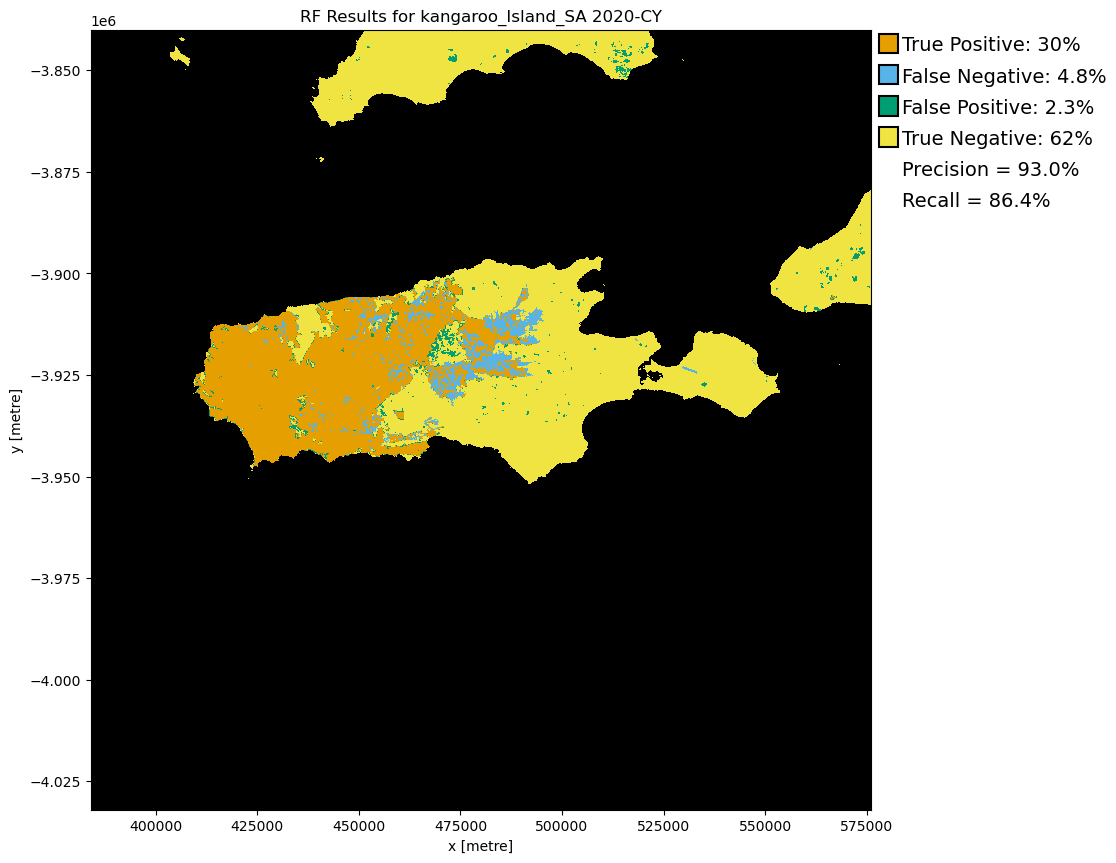

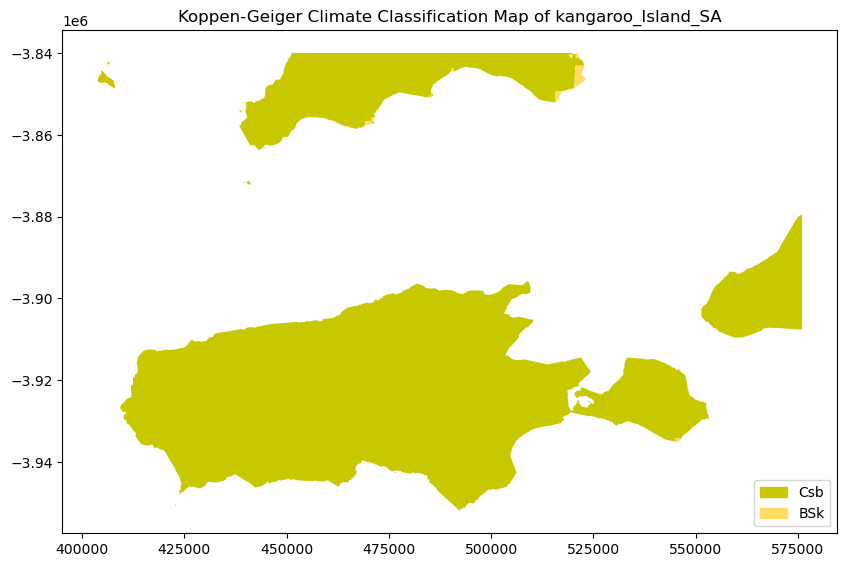


Precision is undefined for Climate Class BSk

Recall is undefined for Climate Class BSk

Precision is 93.17% for Climate Class Csb

Recall is 86.35% for Climate Class Csb
Start Date: 2019-12-01
End Date: 2020-12-31
East_Vic RF ['East_Vic_RF/ga_ls_rf_cyear_3_x41y13_2020_demo.tif', 'East_Vic_RF/ga_ls_rf_cyear_3_x41y14_2020_demo.tif', 'East_Vic_RF/ga_ls_rf_cyear_3_x42y13_2020_demo.tif', 'East_Vic_RF/ga_ls_rf_cyear_3_x42y14_2020_demo.tif', 'East_Vic_RF/ga_ls_rf_cyear_3_x43y13_2020_demo.tif', 'East_Vic_RF/ga_ls_rf_cyear_3_x43y14_2020_demo.tif', 'East_Vic_RF/ga_ls_rf_cyear_3_x44y13_2020_demo.tif', 'East_Vic_RF/ga_ls_rf_cyear_3_x44y14_2020_demo.tif']
CombineArray created by xarray merge
East_Vic RF {'precision': 0.7903596605350834, 'recall': 0.9291218514425766, 'f1-score': 0.8541417002585647}


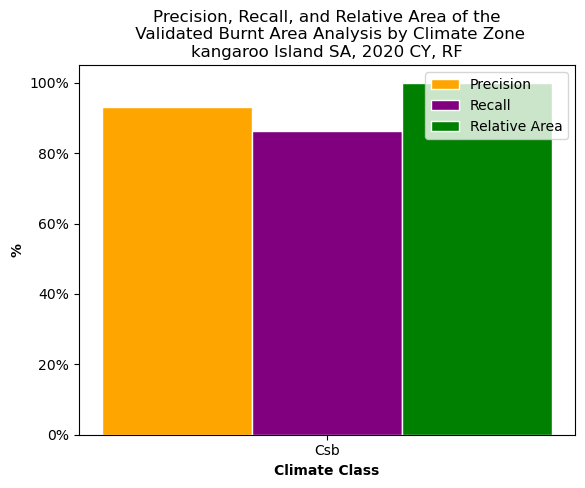

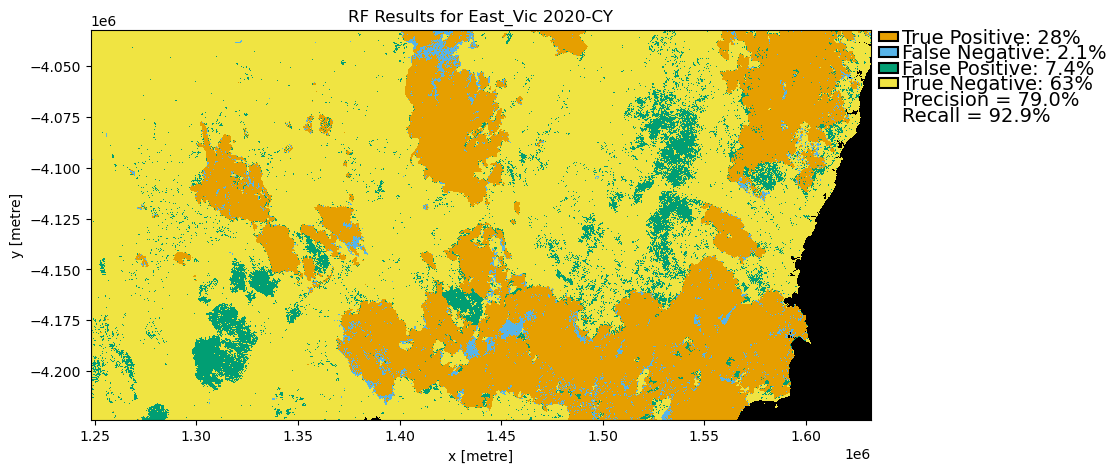

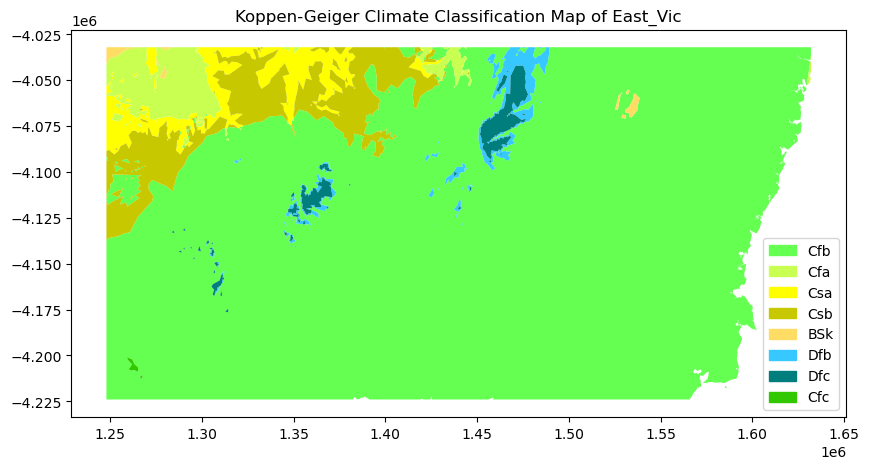


Precision is undefined for Climate Class BSk

Recall is undefined for Climate Class BSk

Precision is 80.54% for Climate Class Csa

Recall is 25.11% for Climate Class Csa

Precision is 82.46% for Climate Class Csb

Recall is 70.96% for Climate Class Csb

Precision is 83.72% for Climate Class Cfa

Recall is 23.65% for Climate Class Cfa

Precision is 78.96% for Climate Class Cfb

Recall is 93.82% for Climate Class Cfb

Precision is undefined for Climate Class Cfc

Recall is undefined for Climate Class Cfc

Precision is 93.3% for Climate Class Dfb

Recall is 97.21% for Climate Class Dfb

Precision is 66.33% for Climate Class Dfc

Recall is 85.73% for Climate Class Dfc
Start Date: 2019-12-01
End Date: 2020-12-31
Cairns_QLD RF ['Cairns_QLD_RF/ga_ls_xgb_cyear_3_x42y35_2020_demo.tif', 'Cairns_QLD_RF/ga_ls_xgb_cyear_3_x42y36_2020_demo.tif', 'Cairns_QLD_RF/ga_ls_xgb_cyear_3_x42y37_2020_demo.tif', 'Cairns_QLD_RF/ga_ls_xgb_cyear_3_x43y35_2020_demo.tif', 'Cairns_QLD_RF/ga_ls_xgb_cyear_3_x43y36_20

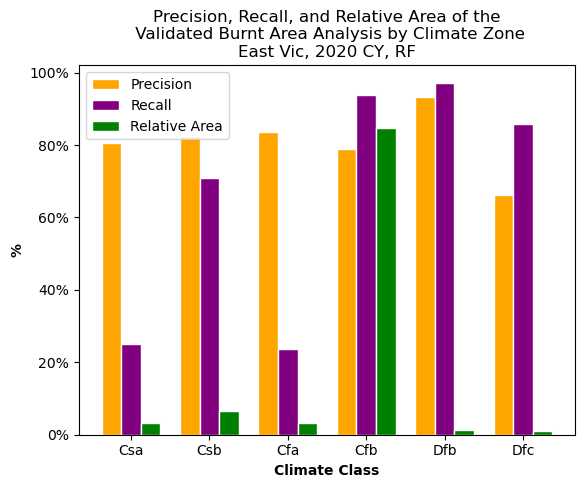

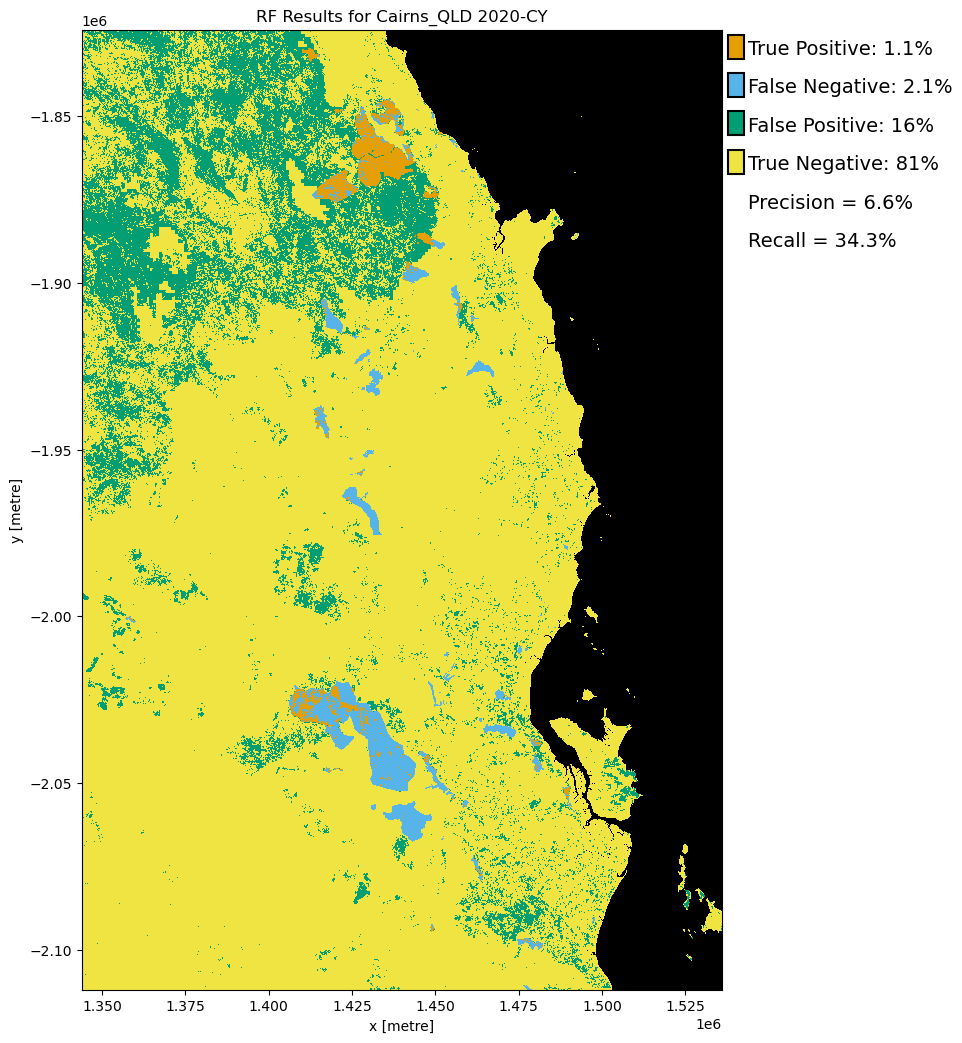

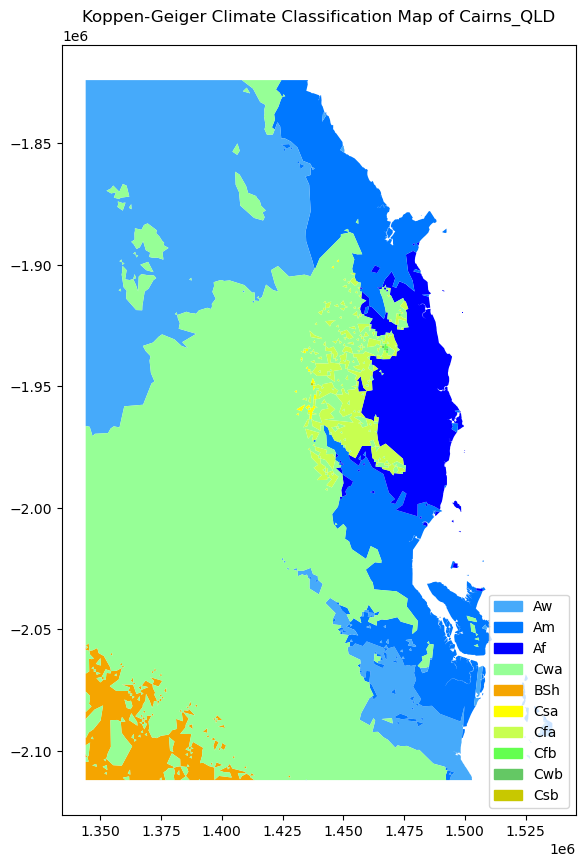


Precision is 0.01% for Climate Class Af

Recall is 0.06% for Climate Class Af

Precision is 16.18% for Climate Class Am

Recall is 56.9% for Climate Class Am

Precision is 4.21% for Climate Class Aw

Recall is 76.06% for Climate Class Aw

Precision is undefined for Climate Class BSh

Recall is undefined for Climate Class BSh

Precision is undefined for Climate Class Csa

Recall is undefined for Climate Class Csa

Precision is undefined for Climate Class Csb

Recall is undefined for Climate Class Csb

Precision is 12.57% for Climate Class Cwa

Recall is 13.48% for Climate Class Cwa

Precision is undefined for Climate Class Cwb

Recall is undefined for Climate Class Cwb

Precision is undefined for Climate Class Cfa

Recall is undefined for Climate Class Cfa

Precision is undefined for Climate Class Cfb

Recall is undefined for Climate Class Cfb
Start Date: 2019-12-01
End Date: 2020-12-31
Cooktown_QLD RF ['Cooktown_QLD_RF/ga_ls_rf_cyear_3_x40y39_2020_demo.tif', 'Cooktown_QLD_RF/ga_ls_rf_

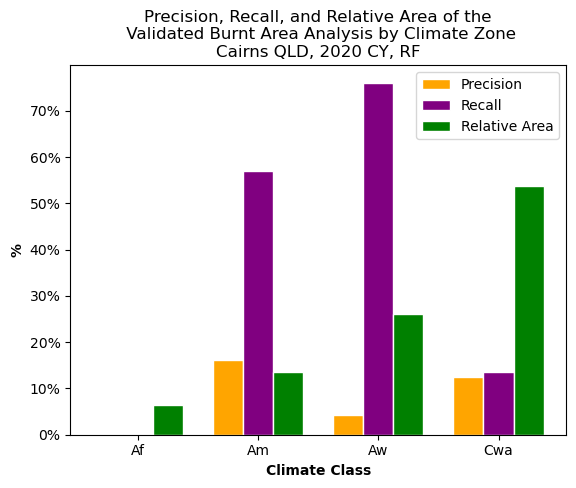

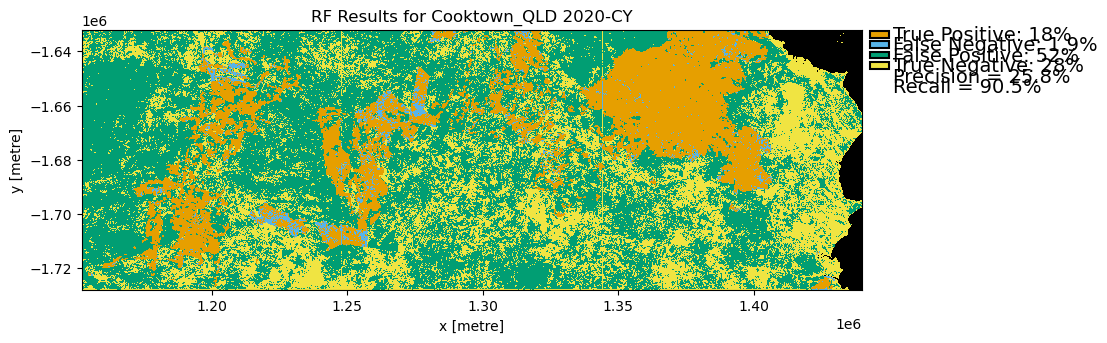

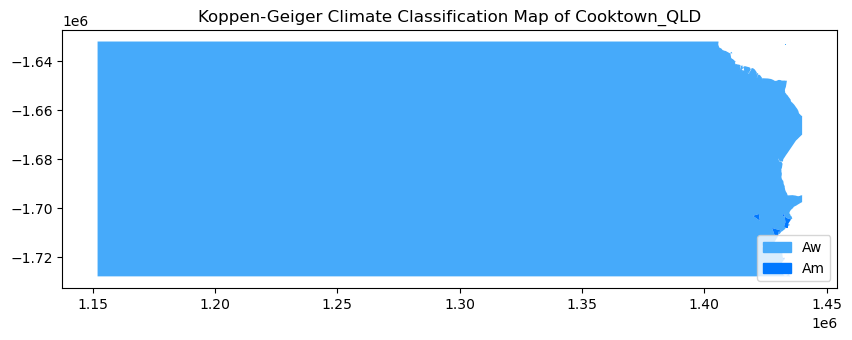


Precision is undefined for Climate Class Am

Recall is undefined for Climate Class Am

Precision is 25.84% for Climate Class Aw

Recall is 90.53% for Climate Class Aw
Start Date: 2019-12-01
End Date: 2020-12-31
Esperance_WA RF ['Esperance_WA_RF/ga_ls_rf_cyear_3_x15y18_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x15y19_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x15y20_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x16y18_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x16y19_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x16y20_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x17y18_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x17y19_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x17y20_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x18y18_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x18y19_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x18y20_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyear_3_x19y18_2020_demo.tif', 'Esperance_WA_RF/ga_ls_rf_cyea

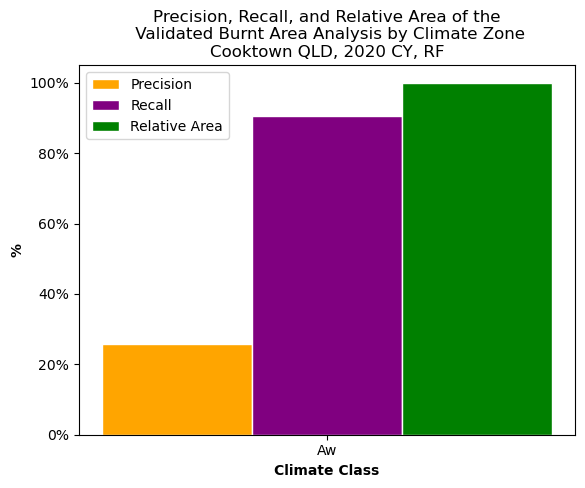

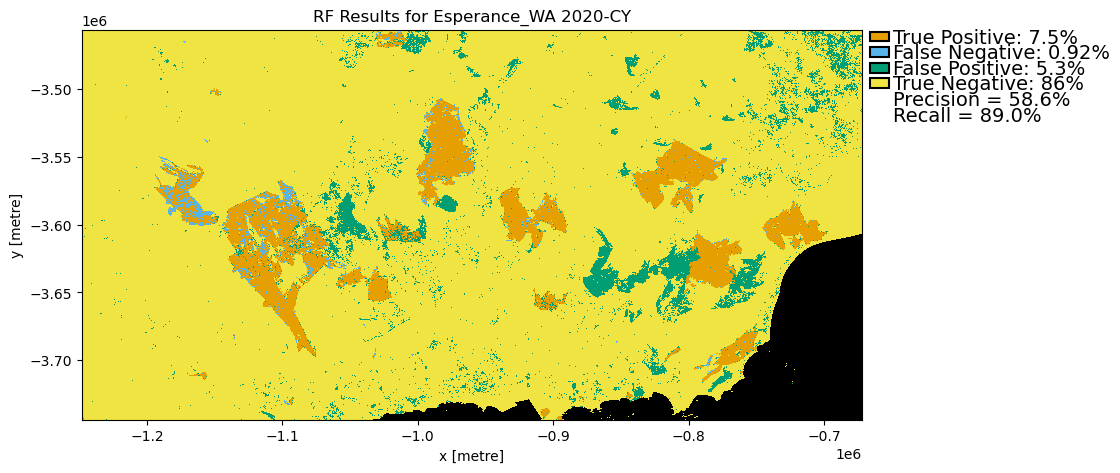

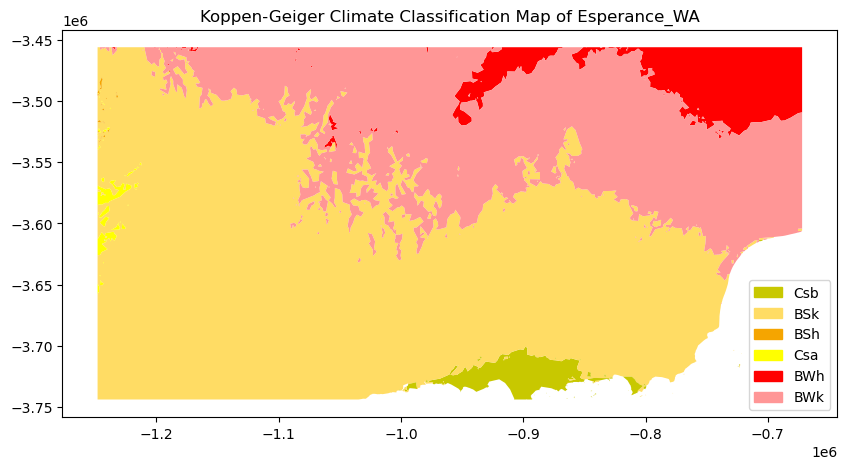


Precision is undefined for Climate Class BWh

Recall is undefined for Climate Class BWh

Precision is 69.11% for Climate Class BWk

Recall is 94.26% for Climate Class BWk

Precision is undefined for Climate Class BSh

Recall is undefined for Climate Class BSh

Precision is 60.61% for Climate Class BSk

Recall is 86.31% for Climate Class BSk

Precision is undefined for Climate Class Csa

Recall is undefined for Climate Class Csa

Precision is 27.09% for Climate Class Csb

Recall is 94.24% for Climate Class Csb
Start Date: 2019-12-01
End Date: 2020-12-31
Port_Hedland_WA RF ['Port_Hedland_WA_RF/ga_ls_rf_cyear_3_x14y32_2020_demo.tif', 'Port_Hedland_WA_RF/ga_ls_rf_cyear_3_x14y33_2020_demo.tif', 'Port_Hedland_WA_RF/ga_ls_rf_cyear_3_x15y32_2020_demo.tif', 'Port_Hedland_WA_RF/ga_ls_rf_cyear_3_x15y33_2020_demo.tif']
CombineArray created by xarray merge
Port_Hedland_WA RF {'precision': 0.018045767985763187, 'recall': 0.19444654787770058, 'f1-score': 0.03302648638728408}


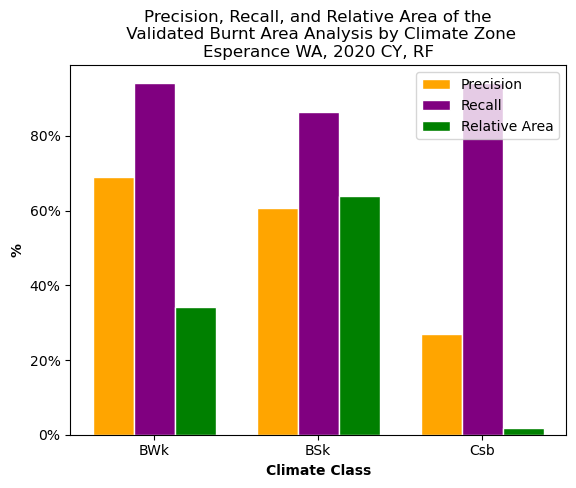

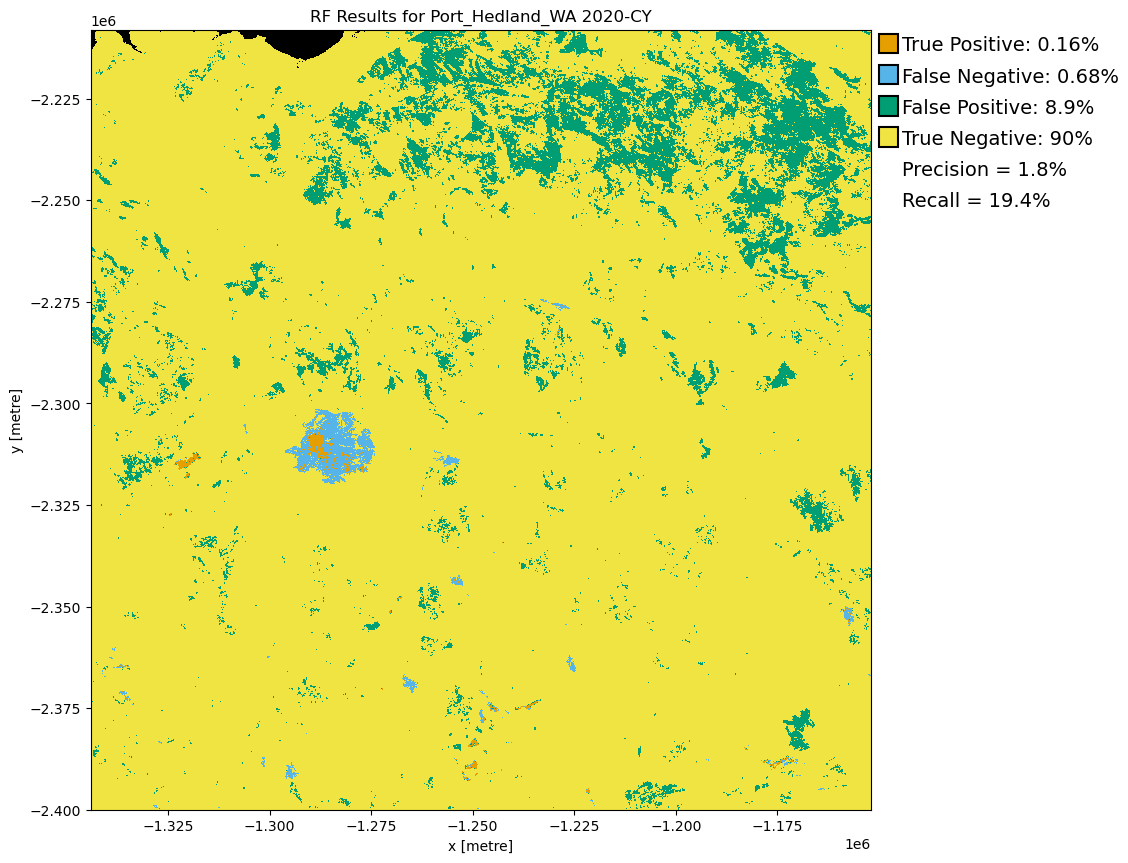

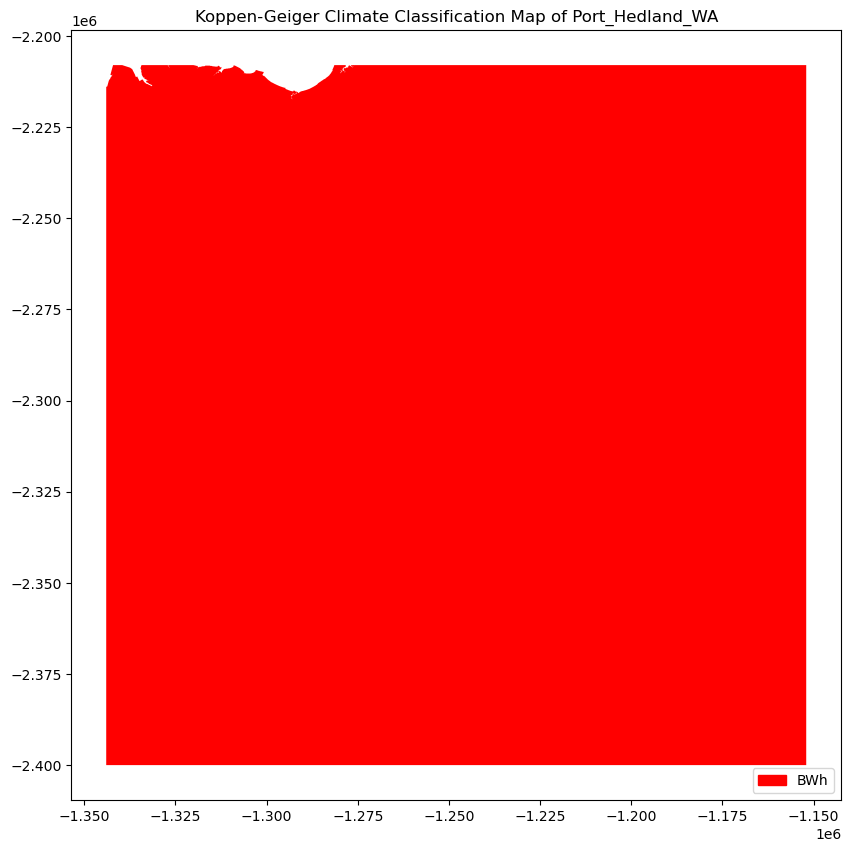


Precision is 1.8% for Climate Class BWh

Recall is 19.44% for Climate Class BWh
Start Date: 2019-12-01
End Date: 2020-12-31
kangaroo_Island_SA XGB ['kangaroo_Island_SA_XGB/ga_ls_xgb_cyear_3_x32y15_2020_demo.tif', 'kangaroo_Island_SA_XGB/ga_ls_xgb_cyear_3_x32y16_2020_demo.tif', 'kangaroo_Island_SA_XGB/ga_ls_xgb_cyear_3_x33y15_2020_demo.tif', 'kangaroo_Island_SA_XGB/ga_ls_xgb_cyear_3_x33y16_2020_demo.tif']
CombineArray created by xarray merge
kangaroo_Island_SA XGB {'precision': 0.9410851805362084, 'recall': 0.8492987173310182, 'f1-score': 0.8928391700581572}


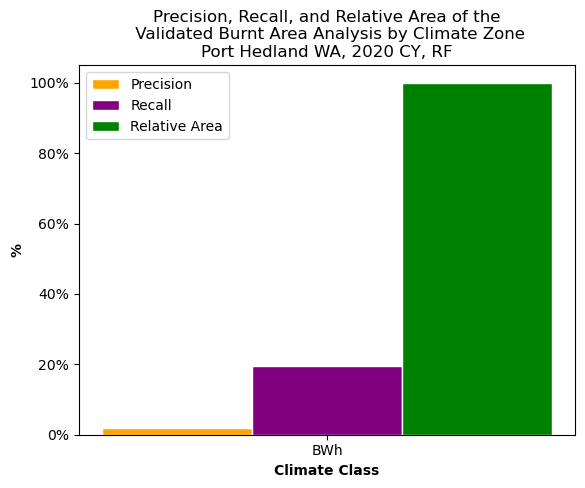

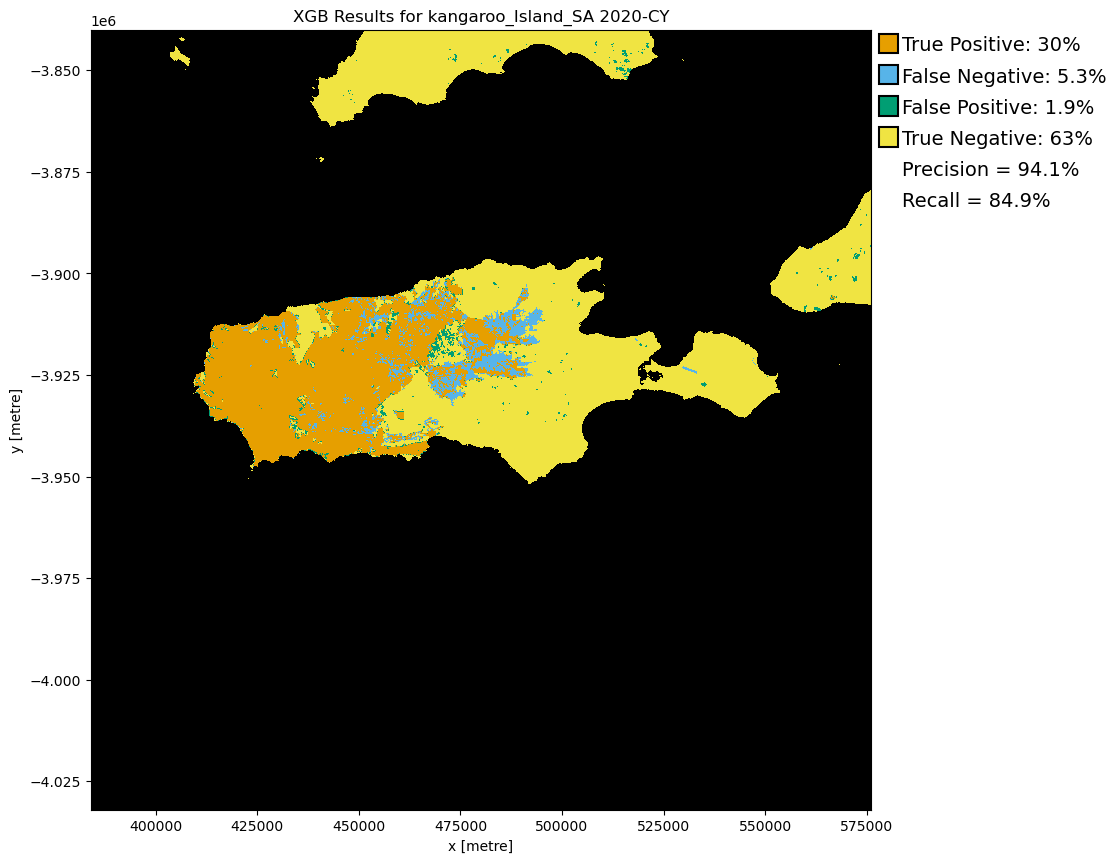

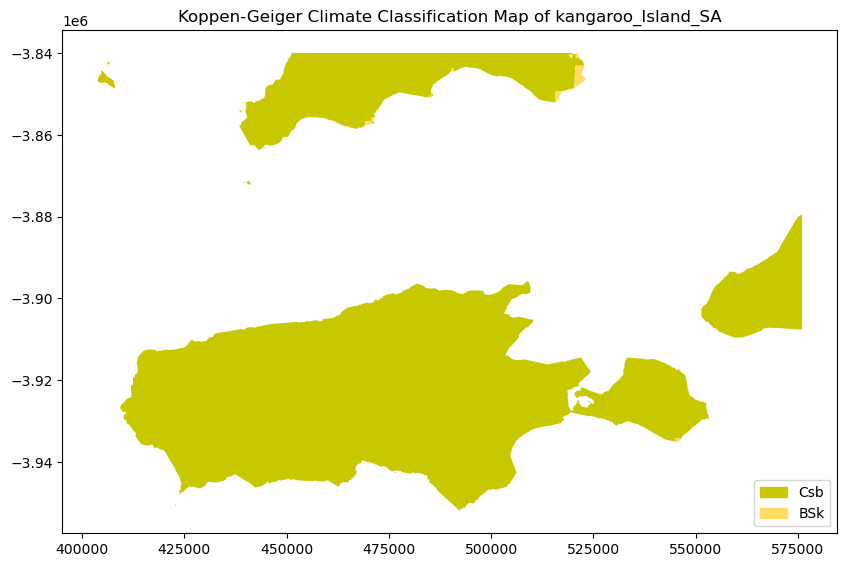


Precision is undefined for Climate Class BSk

Recall is undefined for Climate Class BSk

Precision is 94.29% for Climate Class Csb

Recall is 84.92% for Climate Class Csb
Start Date: 2019-12-01
End Date: 2020-12-31
East_Vic XGB ['East_Vic_XGB/ga_ls_xgb_cyear_3_x41y13_2020_demo.tif', 'East_Vic_XGB/ga_ls_xgb_cyear_3_x41y14_2020_demo.tif', 'East_Vic_XGB/ga_ls_xgb_cyear_3_x42y13_2020_demo.tif', 'East_Vic_XGB/ga_ls_xgb_cyear_3_x42y14_2020_demo.tif', 'East_Vic_XGB/ga_ls_xgb_cyear_3_x43y13_2020_demo.tif', 'East_Vic_XGB/ga_ls_xgb_cyear_3_x43y14_2020_demo.tif', 'East_Vic_XGB/ga_ls_xgb_cyear_3_x44y13_2020_demo.tif', 'East_Vic_XGB/ga_ls_xgb_cyear_3_x44y14_2020_demo.tif']
CombineArray created by xarray merge
East_Vic XGB {'precision': 0.8490211053275424, 'recall': 0.9068935819092979, 'f1-score': 0.8770036459330912}


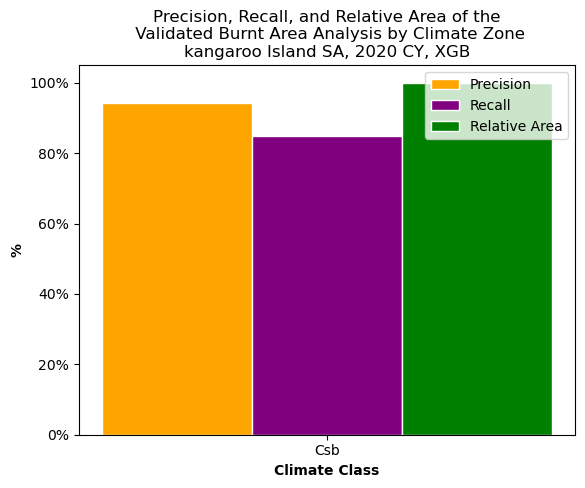

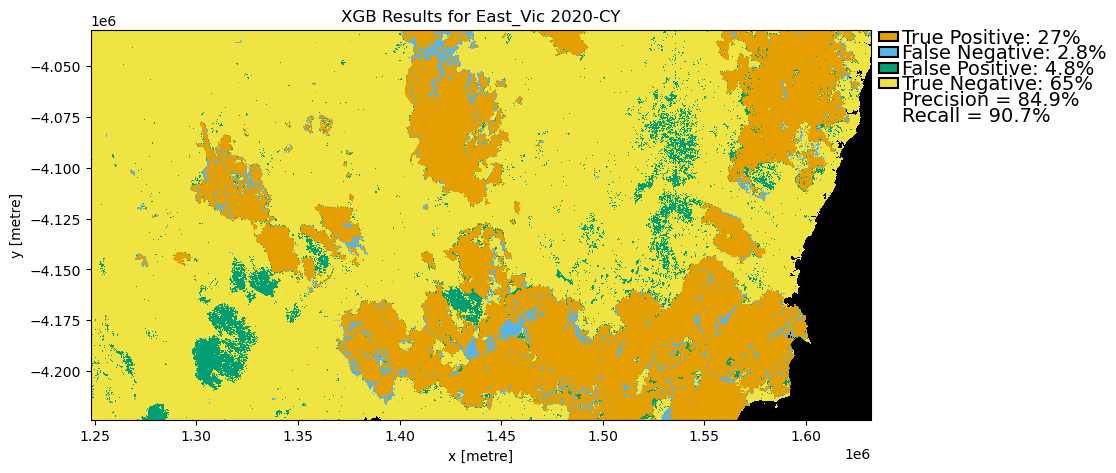

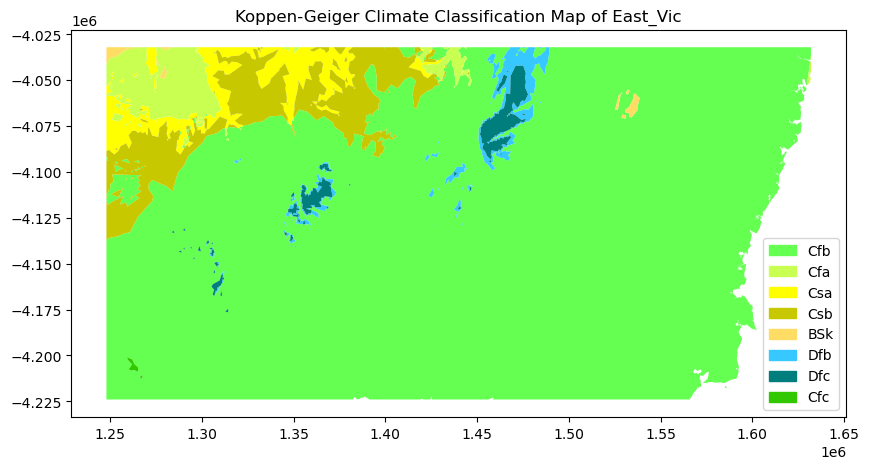


Precision is undefined for Climate Class BSk

Recall is undefined for Climate Class BSk

Precision is 91.09% for Climate Class Csa

Recall is 28.02% for Climate Class Csa

Precision is 89.37% for Climate Class Csb

Recall is 69.61% for Climate Class Csb

Precision is 92.54% for Climate Class Cfa

Recall is 27.23% for Climate Class Cfa

Precision is 84.86% for Climate Class Cfb

Recall is 91.51% for Climate Class Cfb

Precision is undefined for Climate Class Cfc

Recall is undefined for Climate Class Cfc

Precision is 95.49% for Climate Class Dfb

Recall is 97.43% for Climate Class Dfb

Precision is 73.06% for Climate Class Dfc

Recall is 87.07% for Climate Class Dfc
Start Date: 2019-12-01
End Date: 2020-12-31
Cairns_QLD XGB ['Cairns_QLD_XGB/ga_ls_rf_cyear_3_x42y35_2020_demo.tif', 'Cairns_QLD_XGB/ga_ls_rf_cyear_3_x42y36_2020_demo.tif', 'Cairns_QLD_XGB/ga_ls_rf_cyear_3_x42y37_2020_demo.tif', 'Cairns_QLD_XGB/ga_ls_rf_cyear_3_x43y35_2020_demo.tif', 'Cairns_QLD_XGB/ga_ls_rf_cyear_3_x43y36_

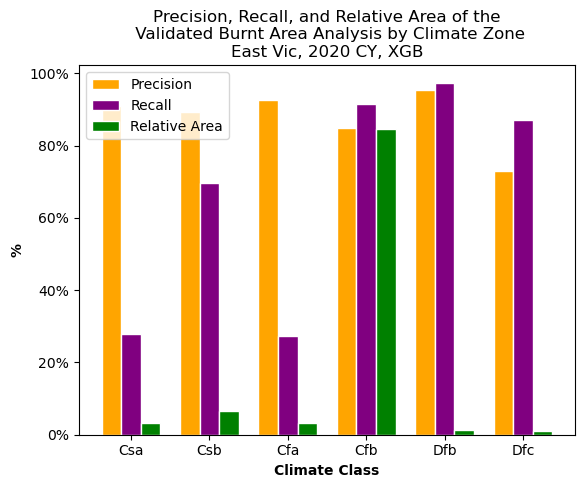

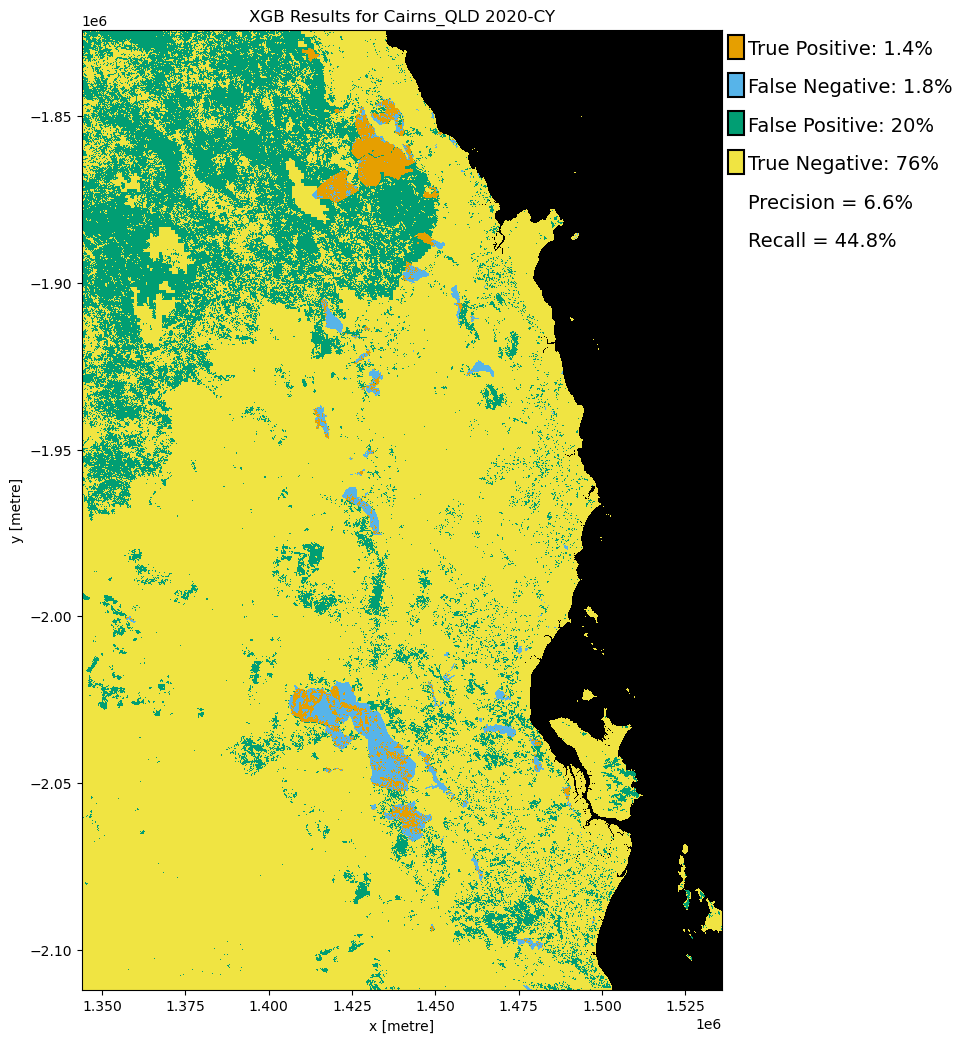

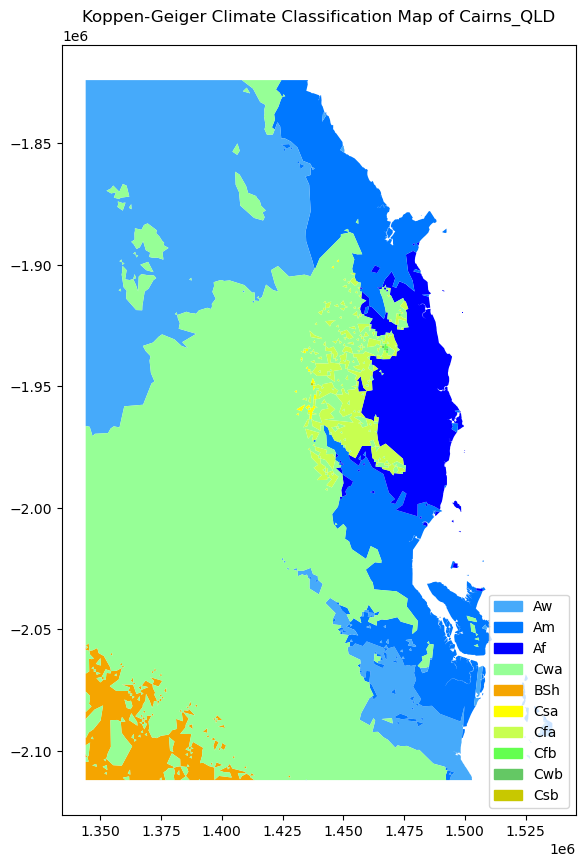


Precision is 0.1% for Climate Class Af

Recall is 0.74% for Climate Class Af

Precision is 14.13% for Climate Class Am

Recall is 58.08% for Climate Class Am

Precision is 3.63% for Climate Class Aw

Recall is 80.08% for Climate Class Aw

Precision is undefined for Climate Class BSh

Recall is undefined for Climate Class BSh

Precision is undefined for Climate Class Csa

Recall is undefined for Climate Class Csa

Precision is undefined for Climate Class Csb

Recall is undefined for Climate Class Csb

Precision is 14.49% for Climate Class Cwa

Recall is 29.19% for Climate Class Cwa

Precision is undefined for Climate Class Cwb

Recall is undefined for Climate Class Cwb

Precision is 0.25% for Climate Class Cfa

Recall is 7.33% for Climate Class Cfa

Precision is undefined for Climate Class Cfb

Recall is undefined for Climate Class Cfb
Start Date: 2019-12-01
End Date: 2020-12-31
Cooktown_QLD XGB ['Cooktown_QLD_XGB/ga_ls_xgb_cyear_3_x40y39_2020_demo.tif', 'Cooktown_QLD_XGB/ga_ls_xgb_cye

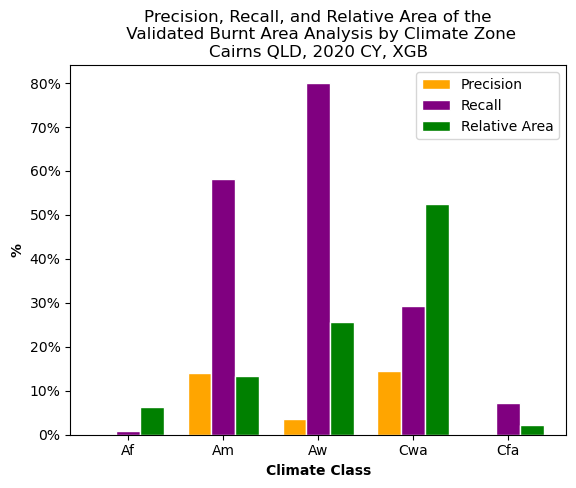

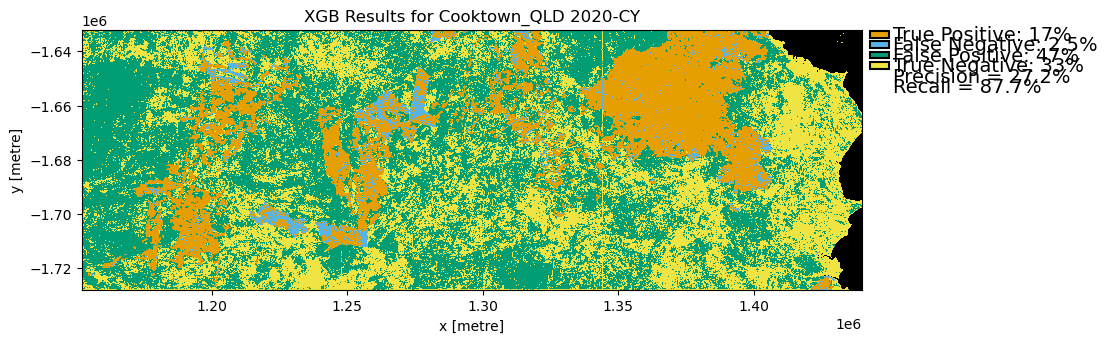

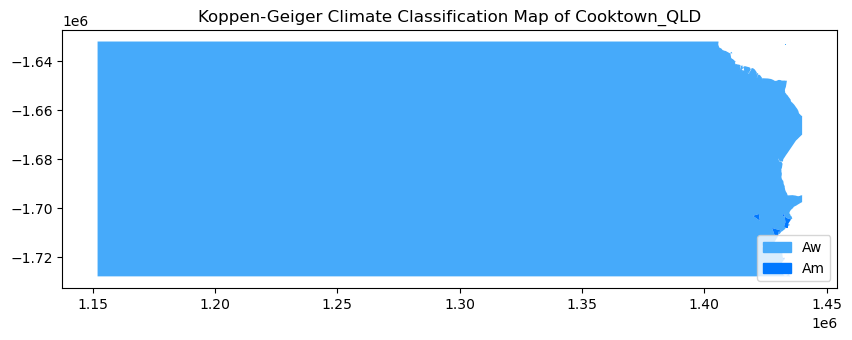


Precision is undefined for Climate Class Am

Recall is undefined for Climate Class Am

Precision is 27.17% for Climate Class Aw

Recall is 87.66% for Climate Class Aw
Start Date: 2019-12-01
End Date: 2020-12-31
Esperance_WA XGB ['Esperance_WA_XGB/ga_ls_xgb_cyear_3_x15y18_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x15y19_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x15y20_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x16y18_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x16y19_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x16y20_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x17y18_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x17y19_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x17y20_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x18y18_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x18y19_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x18y20_2020_demo.tif', 'Esperance_WA_XGB/ga_ls_xgb_cyear_3_x19y18_2020_demo.tif', 'Es

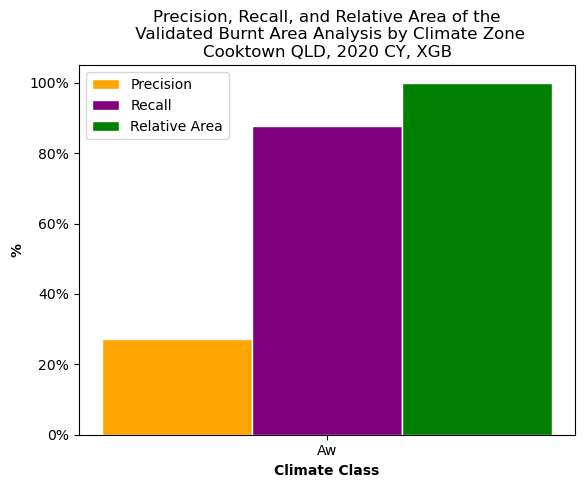

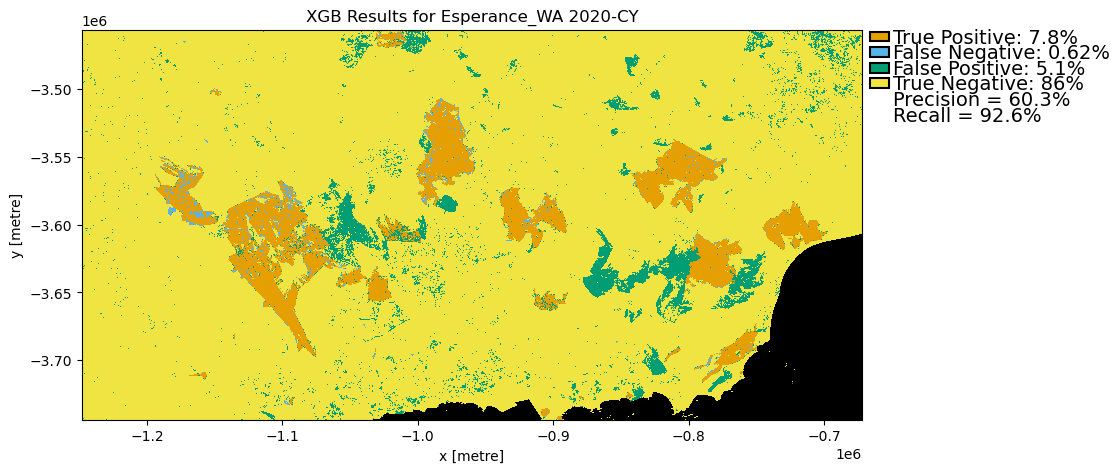

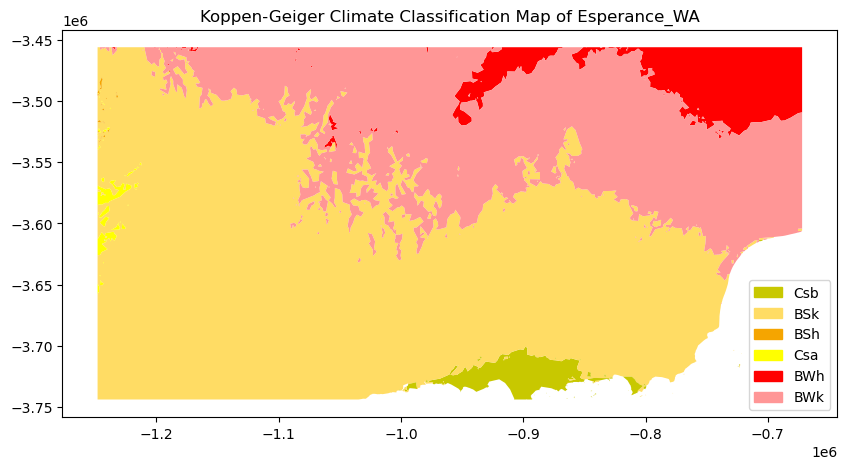


Precision is undefined for Climate Class BWh

Recall is undefined for Climate Class BWh

Precision is 73.08% for Climate Class BWk

Recall is 94.41% for Climate Class BWk

Precision is undefined for Climate Class BSh

Recall is undefined for Climate Class BSh

Precision is 58.98% for Climate Class BSk

Recall is 91.65% for Climate Class BSk

Precision is undefined for Climate Class Csa

Recall is undefined for Climate Class Csa

Precision is 28.44% for Climate Class Csb

Recall is 89.43% for Climate Class Csb
Start Date: 2019-12-01
End Date: 2020-12-31
Port_Hedland_WA XGB ['Port_Hedland_WA_XGB/ga_ls_xgb_cyear_3_x14y32_2020_demo.tif', 'Port_Hedland_WA_XGB/ga_ls_xgb_cyear_3_x14y33_2020_demo.tif', 'Port_Hedland_WA_XGB/ga_ls_xgb_cyear_3_x15y32_2020_demo.tif', 'Port_Hedland_WA_XGB/ga_ls_xgb_cyear_3_x15y33_2020_demo.tif']
CombineArray created by xarray merge
Port_Hedland_WA XGB {'precision': 0.019498353815288853, 'recall': 0.18288413707136075, 'f1-score': 0.035239605918462466}


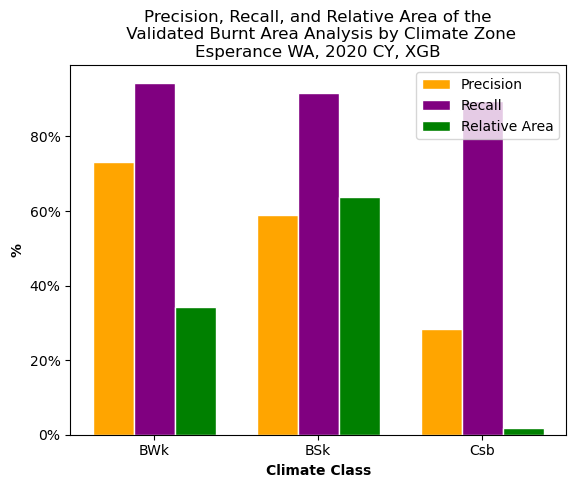

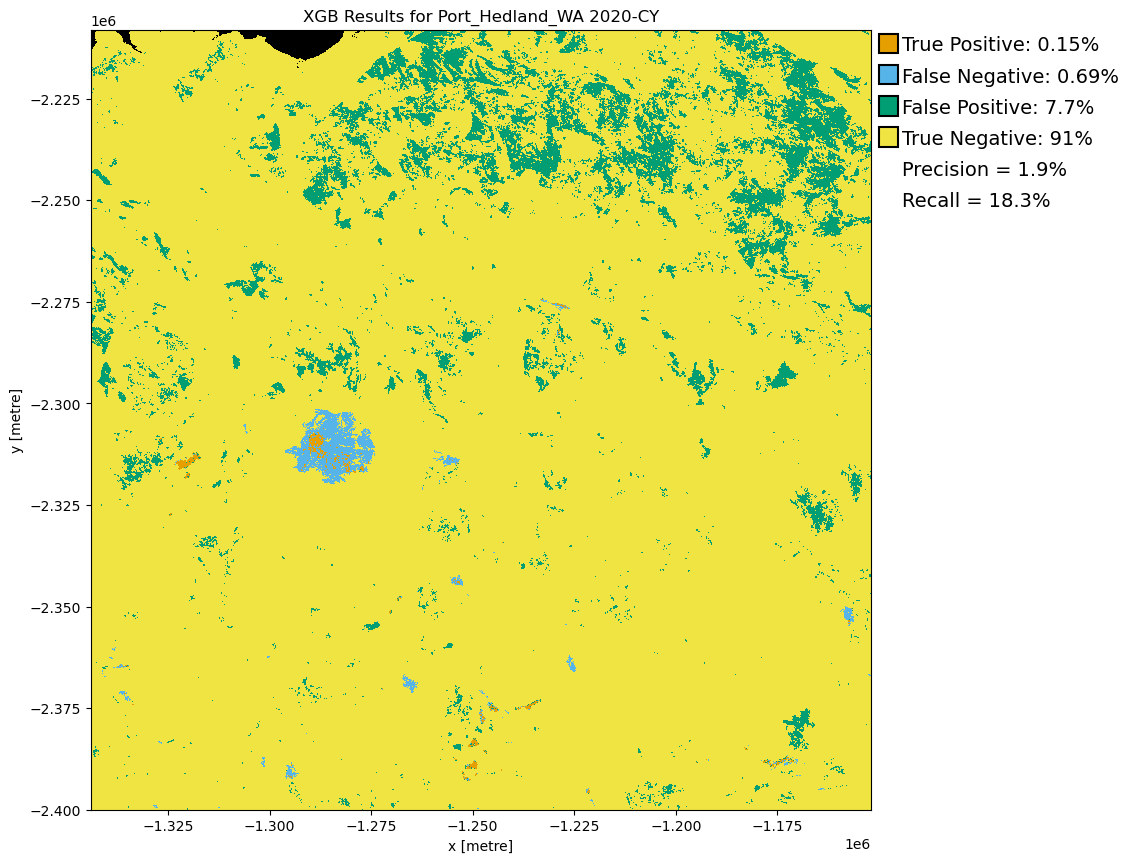

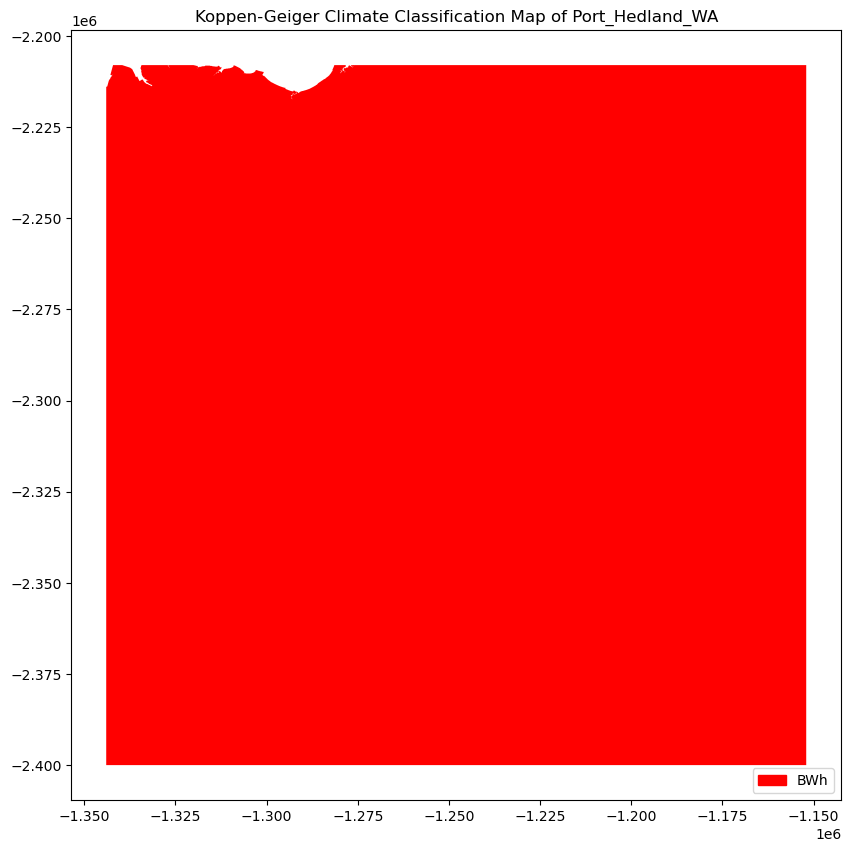


Precision is 1.95% for Climate Class BWh

Recall is 18.29% for Climate Class BWh


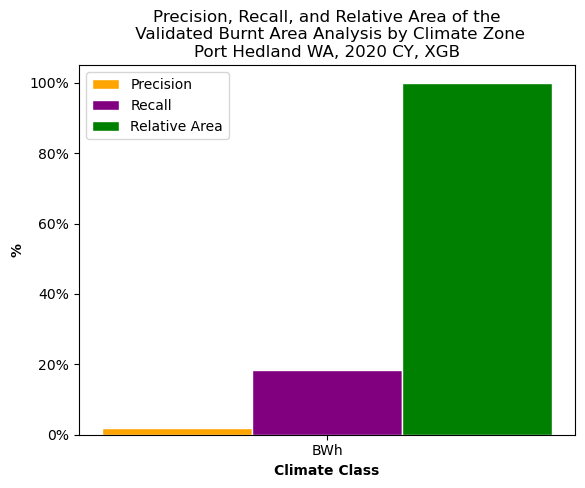

In [7]:
# Open each tif file in the sae_folder directory and calculate bounding extent using the raster_folder_bbox tool

algo_names = ["RF", "XGB", ""]

study_sites = ["kangaroo_Island_SA", "East_Vic", "Cairns_QLD", "Cooktown_QLD", "Esperance_WA", "Port_Hedland_WA"]

for algo_name in algo_names:
    for study_site in study_sites:
        save_folder = f"{study_site}_{algo_name}"

        generate_result_by_study_site_folder(algo_name, save_folder, study_site)

In [8]:
print("Python:", sys.version)
print("Boto3:", boto3.__version__)
print("Botocore:", botocore.__version__)
print("Rasterio:", rasterio.__version__)
print("Geopandas:", gpd.__version__)
print("Contextily:", cx.__version__)
print("Datacube:", datacube.__version__)
print("Xarray:", xr.__version__)
print("Numpy:", np.__version__)
print("Rioxarray:", rioxarray.__version__)

Python: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]
Boto3: 1.28.64
Botocore: 1.31.64
Rasterio: 1.3.8
Geopandas: 0.14.1
Contextily: 1.4.0
Datacube: 1.8.17
Xarray: 2023.10.1
Numpy: 1.26.0
Rioxarray: 0.15.0
